# **New Functionality for DistributedArrays.jl**
### Nick Schickel, Chemical Engineering

## Outline

### 1) Motivation - Roadmap for DistributedArrays.jl

### 2) Star Framework

### 3) cumsum for Arrays

### 4) cumsum for DArrays - Helper functions

### 5) Things I learned

............................................................

### Motivation

https://github.com/JuliaParallel/DistributedArrays.jl/issues/4

In [18]:
addprocs(4)

4-element Array{Int64,1}:
 6
 7
 8
 9

In [20]:
@everywhere using DistributedArrays

In [22]:
ds = DArray((1,8),workers()[1:4],[1,4]) do I
    rand(1:10,map(length,I)...)
end

1×8 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 7  10  4  3  5  10  3  7

In [23]:
cumsum(ds,2)

LoadError: LoadError: indexed assignment not defined for DistributedArrays.DArray{Int64,2,Array{Int64,2}}
while loading In[23], in expression starting on line 1

### Star Framework

In [5]:
function star(f1,f2,f3,args::DistributedArrays.DArray...)
    
    let args = args    
        
        out1 = [remotecall( ()-> f1( DistributedArrays.localpart(args[1]),args[1].indexes ),p ) for p = args[1].pids]

        out2 = f2(fetch.(out1),args[1].indexes)

        out3 = Array(Future,size(args[1].indexes))
            
            for i = 1:length(args[1].pids)
                p = args[1].pids[i]
                out2i = out2[i]
                out3[i] = remotecall( () ->f3( out2i, DistributedArrays.localpart(args[1]), args[1].indexes ),p )
            end
        
        return DArray(out3)
    end
end

star (generic function with 1 method)

In [24]:
using Images

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in #imread#161(::Array{Any,1}, ::Function, ::String) at ./deprecated.jl:50
 in imread(::String) at ./deprecated.jl:49
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/Nick/.julia/v0.5/IJulia/src/execute_request.jl:169
 in eventloop(::ZMQ.Socket) at /Users/Nick/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##9#15)() at ./task.jl:360
while loading In[7], in expression starting on line 1


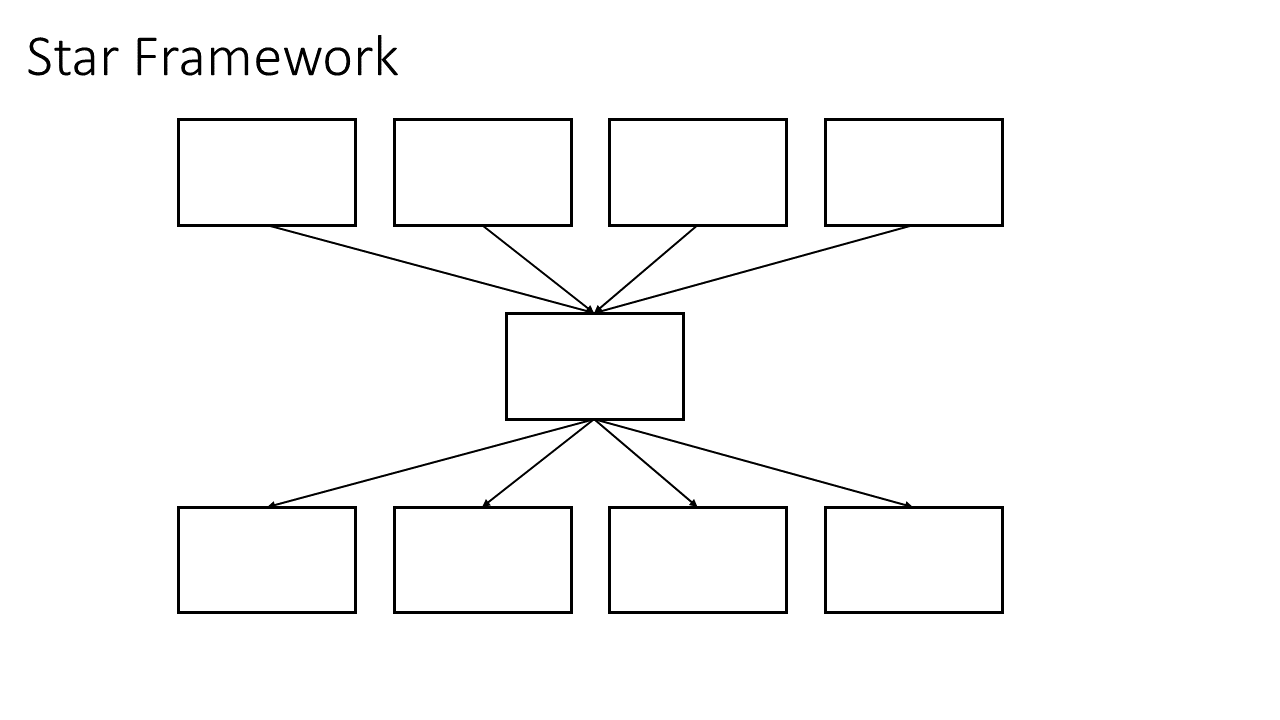

In [7]:
star_image = imread("Slide2.png")

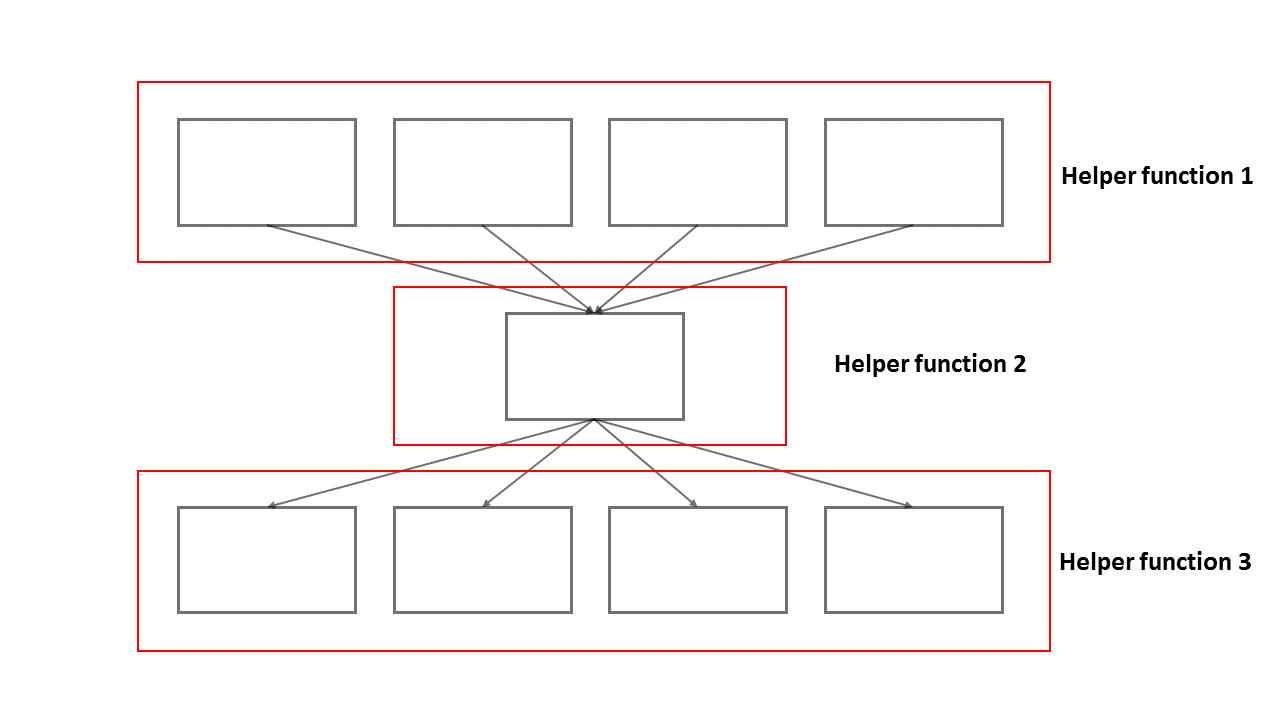

In [8]:
helper_functions = imread("Slide3.png")

### cumsum for Arrays

In [25]:
A = [1; 2; 3; 4]

4-element Array{Int64,1}:
 1
 2
 3
 4

In [26]:
cumsum(A)

4-element Array{Int64,1}:
  1
  3
  6
 10

In [27]:
A = [1 2 3 4]

1×4 Array{Int64,2}:
 1  2  3  4

In [29]:
cumsum(A,2)

1×4 Array{Int64,2}:
 1  3  6  10

In [30]:
A = [1 2 3 4; 5 6 7 8]

2×4 Array{Int64,2}:
 1  2  3  4
 5  6  7  8

In [31]:
cumsum(A)

2×4 Array{Int64,2}:
 1  2   3   4
 6  8  10  12

### cumsum for DArrays

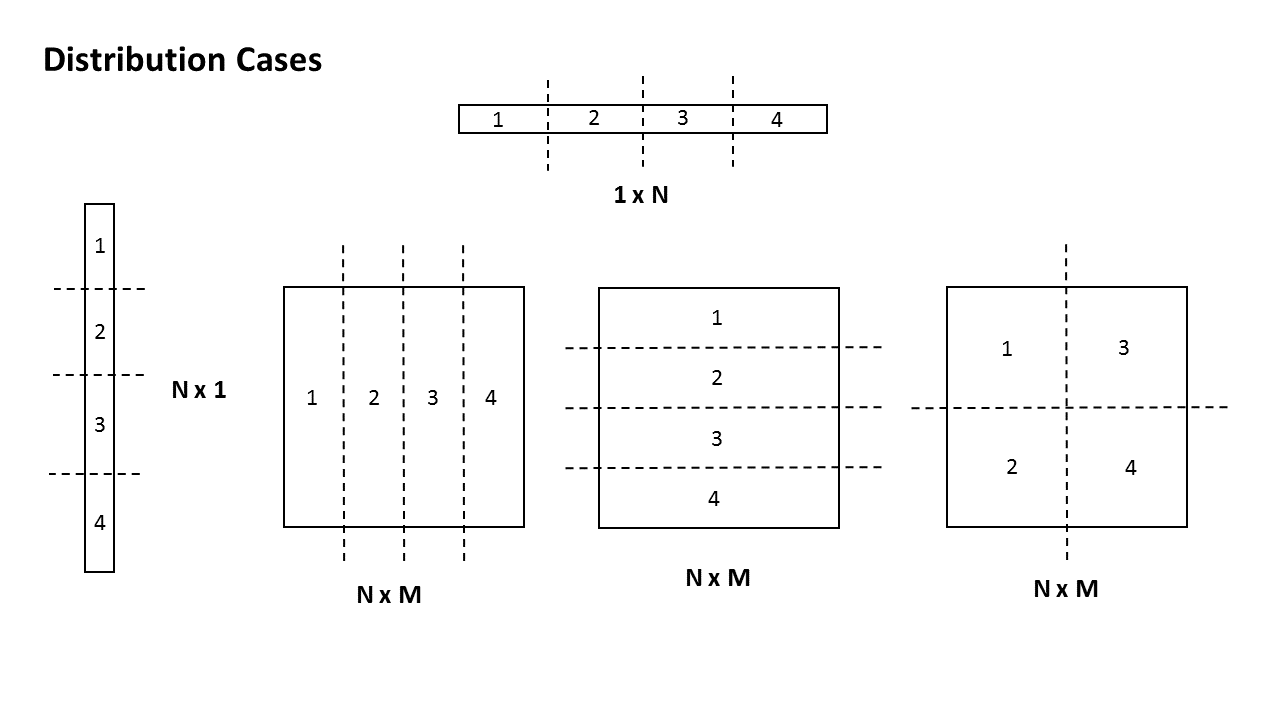

In [9]:
DistributionCases = imread("DistributionCases.png")

In [32]:
@everywhere function cumsum_helper1(A1::AbstractArray,A2::AbstractArray)
    
                if size(A2)[1] == 1 && maximum( [A2[i][1].stop for i = 1:size(A2,2)] ) == 1
                    return cumsum(A1,2)[end]
        
                elseif size(A2)[2] == 1 && maximum( [A2[i][2].stop for i = 1:size(A2,1)] ) == 1
                    return cumsum(A1)[end]
        
                else return cumsum(A1)[size(A1,1),:]'
        
                end
            end

In [33]:
function cumsum_helper2(A::AbstractArray,A2::AbstractArray)          
    if size(A2,1) != size(A,1) && size(A2,2) != size(A,2)
        A = A'
    end
    
    if size(A,1) == 1
        if maximum(size.([A[i] for i = 1:size(A,2)])) == ()
            
            return [0 cumsum(A,2)]  
        else 
            result = []
            
            for i = 1:size(A,2)
                push!(result,zeros(typeof(A[1][1]),size(A[i],2)))
            end
            
            return result
        end
        
    elseif size(A,2) == 1
        
        if maximum(size.([A[i] for i = 1:size(A,1)])) == ()
            return [0; cumsum(A)]
        else 
            return [ [zeros(typeof(A[1][1]),1,size(A[1],2))]; cumsum(A)]
        end
        
    else
        result = []
        for i = 1:size(A,2)
            if size(A[1,i]) == ()
                push!(result,0)
            else
                push!(result,zeros(typeof(A[1][1]),size(A[1,i],2),1))
            end
        end
        
        return [result'; cumsum(A)[1:end-1,:]]
        
    end
end

cumsum_helper2 (generic function with 1 method)

In [34]:
@everywhere function cumsum_helper3(A1::Any,A2::AbstractArray,A3::AbstractArray)
    
                if size(A3)[1] == 1 && maximum( [A3[i][1].stop for i = 1:size(A3,2)] ) == 1
                    return +(A1,cumsum(A2,2))
                                 
                elseif size(A3)[2] == 1 && maximum( [A3[i][2].stop for i = 1:size(A3,1)] ) == 1
                    return +(A1,cumsum(A2))
                         
                else           
                    result = zeros(typeof(A2[1][1]),size(A2))
                                
                    if size(A3,1) == 1
                        for i = 1:size(A2,1)
                            result[i,:] = +(A1,cumsum(A2)[i,:])
                        end
                        return result

                    elseif size(A3,2) == 1
                        for i = 1:size(A2,1)
                            result[i,:] = +(A1,cumsum(A2)[i,:]')
                        end
                        return result

                    else
                        for i = 1:size(A2,1)
                            result[i,:] = +(A1,cumsum(A2)[i,:]')
                        end
                        return result
                    end
        
                end
            end

, AbstractArray) in module Main at In[12]:3 overwritten at In[34]:3.


In [35]:
import Base.cumsum

function cumsum(D::DistributedArrays.DArray)
    star(cumsum_helper1,cumsum_helper2,cumsum_helper3,D)
end

cumsum (generic function with 4 methods)

In [36]:
ds

1×8 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 7  10  4  3  5  10  3  7

In [37]:
cumsum(ds)

1×8 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 7  17  21  24  29  39  42  49

In [38]:
ds = DArray((8,8)) do I
    ones(Int,map(length,I)...)
end

8×8 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1

In [39]:
cumsum(ds)

8×8 DistributedArrays.DArray{Int64,2,Array{Int64,2}}:
 1  1  1  1  1  1  1  1
 2  2  2  2  2  2  2  2
 3  3  3  3  3  3  3  3
 4  4  4  4  4  4  4  4
 5  5  5  5  5  5  5  5
 6  6  6  6  6  6  6  6
 7  7  7  7  7  7  7  7
 8  8  8  8  8  8  8  8

### Things I learned

#### - Shape and dimensions of the DArray are extremely important (and hard to keep track of)
#### - Debugging code running on workers isn't easy
#### - Dr. Andreas Noack (postdoc in Julia group) is a really useful resource

#### Notes

cumsum for distributed arrays not pushed to github yet (should be later today). cumprod for distributed arrays will follow.